In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from researchlib.single_import import *

In [12]:
train_loader = FromDataset(MNIST(True, normalize=False), batch_size=512)
test_loader = FromDataset(MNIST(False, normalize=False), batch_size=512)

In [13]:
encoder = builder([
    nn.Conv2d(1, 256, 9, stride=1, bias=True),
    nn.BatchNorm2d(256),
    nn.SELU(inplace=True),
    PrimaryCapsules(256, 256, 8, kernel_size=9),
    RoutingCapsules(8, 1152, 10, 16, 3)
])

decoder = builder([
    CapsuleMasked(),
    nn.Linear(160, 512),
    nn.BatchNorm1d(512),
    nn.SELU(inplace=True),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.SELU(inplace=True),
    nn.Linear(1024, 784),
    nn.Sigmoid(),
    Reg(Reshape((-1, 1, 28, 28)), 'rc', get='out'),
])

model = builder([
    Reg(Identical(), 'rc', get='out'),
    encoder,
    Split(decoder),
    Norm()
])

In [19]:
runner = Runner(model, train_loader, test_loader, 'adam', 'margin', fp16=False, multigpu=True, reg_fn={'rc': 'mse'}, reg_weights={'rc': 0.1})

In [ ]:
runner.fit(20, 1e-3)

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*        0.0260        0.9924        0.0227        0.9843    


    2         0.0237        0.9925        0.0108        0.9915    


    3         0.0216        0.9942        0.0180        0.9886    


    4         0.0244        0.9925        0.0107        0.9913    


    5         0.0199        0.9947        0.0163        0.9899    


    6         0.0207        0.9940        0.0102        0.9917    


    7         0.0187        0.9956        0.0162        0.9888    


    8         0.0196        0.9948        0.0099        0.9918    


    9         0.0190        0.9957        0.0160        0.9895    


    10        0.0202        0.9947        0.0095        0.9920    


    11        0.0187        0.9957        0.0170        0.9872    


    12        0.0195        0.9947        0.0091        0.9923    


    13        0.0182        0.9960        0.0163        0.9897    


    14        0.0202        0.9950        0.0092        0.9921    


    15        0.0182        0.9961        0.0174        0.9889    


    16        0.0194        0.9952        0.0094        0.9919    


In [16]:
x = next(iter(test_loader))[0]

In [17]:
import torchvision.utils as vutils

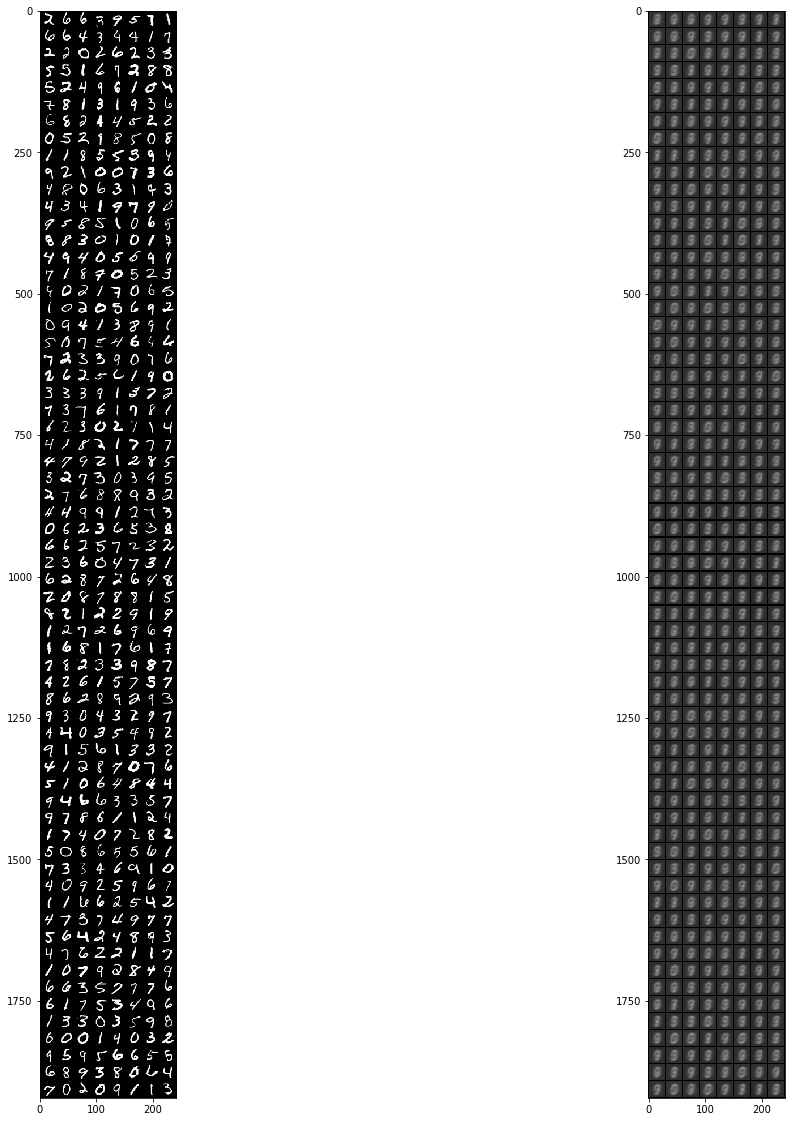

In [18]:
out = encoder(x.cuda())
res = decoder(out)

t1 = vutils.make_grid(x).cpu().numpy().transpose(1,2,0)
t2 = vutils.make_grid(res.detach()).cpu().numpy().transpose(1,2,0)

fig, arr = plt.subplots(1,2,figsize=(20,20))
arr[0].imshow(t1)
arr[1].imshow(t2)
plt.show()